# Exploratory Analysis: Sentence-Level Sentiment (Media + Reddit)

This notebook is an **investigation step** before the overpay/contract analysis.

Goals:
- Understand how many sentiment-labeled sentences we have per source (media vs. Reddit)
- Inspect **tie-breaker** composition (single-player vs multi-player vs pronoun-backfill)
- Summarize how sentences were graded (VADER + DeBERTa ABSA): distributions, averages, and label splits
- Check model agreement/disagreement
- Produce player-level aggregates that later feed into the overpay modeling


In [29]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option("display.max_columns", 200)
plt.rcParams.update({"figure.figsize": (10, 5), "axes.grid": True, "grid.alpha": 0.25})

MEDIA_SENTIMENT_PATH = Path("data/sentiment_data/media_sentence_sentiment.jsonl")
REDDIT_SENTIMENT_PATH = Path("data/sentiment_data/reddit_sentence_sentiment.jsonl")

OUTPUT_DIR = Path("data/sentiment_data/analysis_outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


## Load sentiment outputs

Inputs (written by `scripts/sentiment_pipeline.py`):
- `data/sentiment_data/media_sentence_sentiment.jsonl`
- `data/sentiment_data/reddit_sentence_sentiment.jsonl`

Schema (typical fields):
- `source`, `player`, `sentence`
- `other_players`, `n_other_players`
- `vader`, `vader_label`, plus optional `vader_neg/neu/pos`
- `deberta`, `deberta_label`, plus optional `deberta_neg/neu/pos`
- `tie_breaker` (present when upstream sentence records included it; in this repo it’s available for **media**)


In [47]:
def _ensure_list(value: Any) -> List[Any]:
    if value is None:
        return []
    if isinstance(value, list):
        return value
    if isinstance(value, str):
        s = value.strip()
        if not s:
            return []
        if ";" in s:
            return [p.strip() for p in s.split(";") if p.strip()]
        return [s]
    return [value]


def read_jsonl(path: Path) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue
            if not isinstance(obj, dict):
                continue
            if obj.get("_type") == "url_done":
                continue
            rows.append(obj)
    return pd.DataFrame.from_records(rows)


def normalize_sentiment_df(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    df = df.copy()

    for col in ["source", "player", "sentence", "vader_label", "deberta_label"]:
        if col not in df.columns:
            df[col] = ""
        df[col] = df[col].fillna("").astype(str)

    if "other_players" not in df.columns:
        df["other_players"] = [[] for _ in range(len(df))]
    df["other_players"] = df["other_players"].apply(_ensure_list)

    if "n_other_players" not in df.columns:
        df["n_other_players"] = df["other_players"].apply(lambda x: len([p for p in x if str(p).strip()]))
    df["n_other_players"] = pd.to_numeric(df["n_other_players"], errors="coerce").fillna(0).astype(int)

    # tie_breaker is only present if upstream sentence records included it.
    if "tie_breaker" not in df.columns:
        df["tie_breaker"] = np.nan
    df["tie_breaker"] = df["tie_breaker"].fillna("(missing)").astype(str)

    num_cols = [
        "vader",
        "deberta",
        "vader_neg",
        "vader_neu",
        "vader_pos",
        "deberta_neg",
        "deberta_neu",
        "deberta_pos",
    ]
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df["sentence_len_words"] = df["sentence"].str.split().apply(len)
    df["sentence_len_chars"] = df["sentence"].str.len()

    df["label_agree"] = (df["vader_label"] == df["deberta_label"]) & (df["vader_label"] != "")
    df["score_diff_deberta_minus_vader"] = df["deberta"] - df["vader"]

    return df


media_df = normalize_sentiment_df(read_jsonl(MEDIA_SENTIMENT_PATH))
reddit_df = normalize_sentiment_df(read_jsonl(REDDIT_SENTIMENT_PATH))

sent_df = pd.concat([media_df, reddit_df], ignore_index=True)



## Dataset overview

Quick checks:
- sizes per source
- missingness rates (expected: `tie_breaker` is missing for Reddit)
- duplicates (should be low because the pipeline dedupes on resume)
- sentence-length + other-player noise diagnostics

Snapshot (current run):
- Media: **26,011** sentences across **66** players
- Reddit: **8,095** sentences across **51** players
- Duplicate rows by `(source, player, sentence)`: **0**

Other-player noise is low in both sources: median `n_other_players` is **0** and the 99th percentile is **1** (max: 8 in media, 5 in Reddit).


In [31]:
def missing_rate(df: pd.DataFrame, cols: List[str]) -> pd.Series:
    return df[cols].isna().mean().sort_values(ascending=False)


key_cols = ["source", "player", "sentence", "vader", "deberta", "vader_label", "deberta_label", "n_other_players", "tie_breaker"]
present_cols = [c for c in key_cols if c in sent_df.columns]
display(missing_rate(sent_df, present_cols).rename("missing_rate"))

dup_n = sent_df.duplicated(subset=["source", "player", "sentence"]).sum()
print(f"Duplicate rows by (source,player,sentence): {dup_n:,} / {len(sent_df):,} ({dup_n / max(1, len(sent_df)):.3%})")


source             0.0
player             0.0
sentence           0.0
vader              0.0
deberta            0.0
vader_label        0.0
deberta_label      0.0
n_other_players    0.0
tie_breaker        0.0
Name: missing_rate, dtype: float64

Duplicate rows by (source,player,sentence): 0 / 34,106 (0.000%)


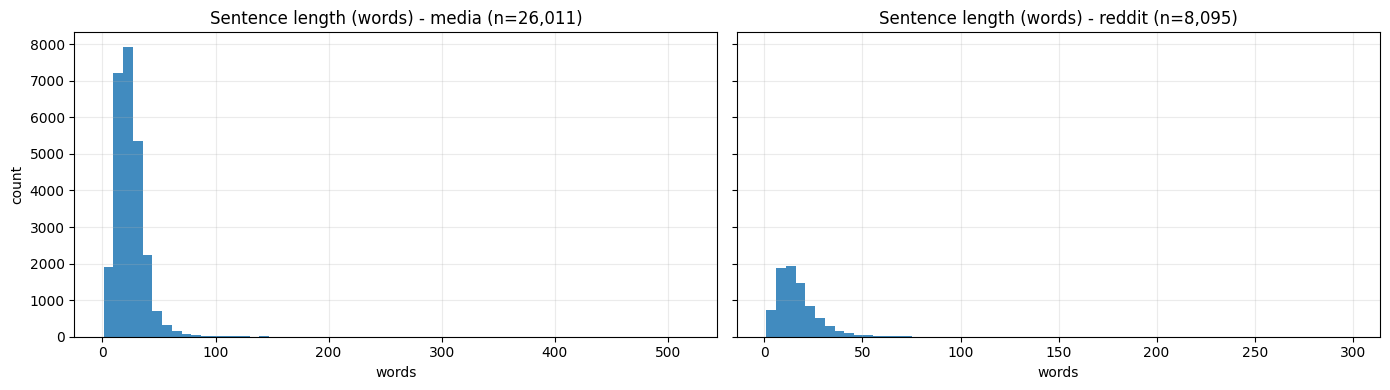

In [32]:
# Sentence length distribution by source
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
for ax, src in zip(axes, ["media", "reddit"]):
    d = sent_df[sent_df["source"] == src]
    ax.hist(d["sentence_len_words"], bins=60, alpha=0.85)
    ax.set_title(f"Sentence length (words) - {src} (n={len(d):,})")
    ax.set_xlabel("words")
axes[0].set_ylabel("count")
plt.tight_layout()


## Tie-breaker composition (sentence assignment diagnostics)

`tie_breaker` tells us **how** a sentence was attributed to a player:
- `single_player`: only one tracked player was explicitly found in the sentence
- `longest_alias_then_count_then_position`: multi-player sentence, primary chosen by deterministic rules
- `pronoun_backfill`: no explicit player in sentence; assigned by pronoun heuristic (context-based)

In this repo, `tie_breaker` is present in the **media** sentiment output (because the media input included it). The Reddit sentiment output was produced from a "lite" dataset without `tie_breaker`, so it appears as `(missing)`.

Snapshot (media, current run):
- `pronoun_backfill`: **16,789 / 26,011 = 64.5%**
- `single_player`: **7,977 / 26,011 = 30.7%**
- `longest_alias_then_count_then_position`: **1,245 / 26,011 = 4.8%**

Why this matters: `pronoun_backfill` sentences are **more neutral on average** (see below), so including them can dilute extremes in player-level media sentiment.


,source,tie_breaker,n,share_within_source
1,media,pronoun_backfill,16789,0.645458
2,media,single_player,7977,0.306678
0,media,longest_alias_then_count_then_position,1245,0.047864
3,reddit,(missing),8095,1.000000


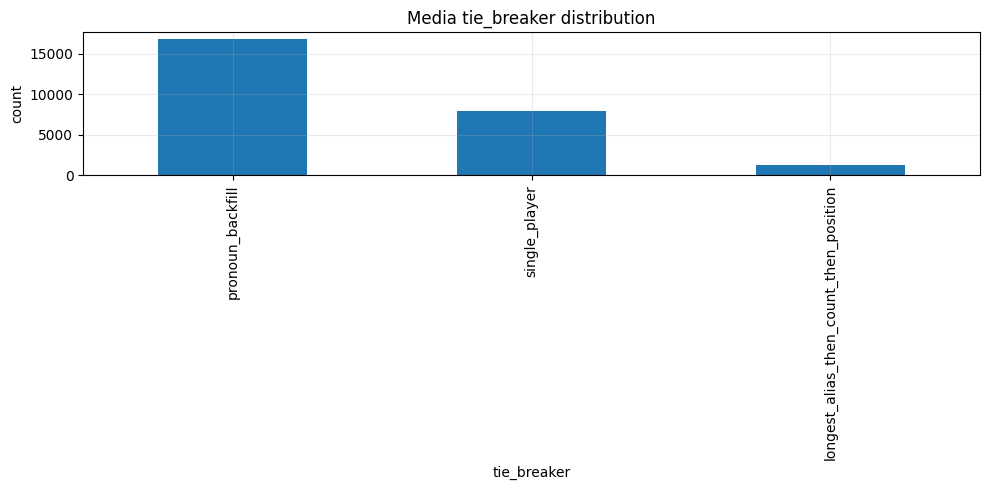

In [33]:
tb_counts = (
    sent_df.groupby(["source", "tie_breaker"]).size().rename("n").reset_index().sort_values(["source", "n"], ascending=[True, False])
)
tb_counts["share_within_source"] = tb_counts.groupby("source")["n"].transform(lambda s: s / s.sum())
display(tb_counts)

media_tb = sent_df[sent_df["source"] == "media"]["tie_breaker"].value_counts()
ax = media_tb.plot(kind="bar", title="Media tie_breaker distribution")
ax.set_xlabel("tie_breaker")
ax.set_ylabel("count")
plt.tight_layout()


In [34]:
# How much "other-player" noise do we have per tie_breaker? (media only)
media_only = sent_df[sent_df["source"] == "media"].copy()

tb_noise = (
    media_only.groupby("tie_breaker")
    .agg(
        n=("sentence", "size"),
        mean_n_other_players=("n_other_players", "mean"),
        median_n_other_players=("n_other_players", "median"),
        p95_n_other_players=("n_other_players", lambda s: float(np.percentile(s, 95))),
    )
    .sort_values("n", ascending=False)
    .reset_index()
)
display(tb_noise)


,tie_breaker,n,mean_n_other_players,median_n_other_players,p95_n_other_players
0,pronoun_backfill,16789,0.000000,0.0,0.0
1,single_player,7977,0.000000,0.0,0.0
2,longest_alias_then_count_then_position,1245,1.279518,1.0,3.0


## How were sentences graded? (score + label summaries)

We summarize:
- mean/median sentiment score
- label distribution (Positive/Neutral/Negative)
- split by source (media vs Reddit)
- split by `tie_breaker` for media

Snapshot (current run):
- Media is slightly positive on average (mean VADER ~ **0.19**, mean DeBERTa ~ **0.11**).
- Reddit is positive by VADER but negative by DeBERTa on average (mean VADER ~ **0.13**, mean DeBERTa ~ **-0.11**).

A key pattern: DeBERTa assigns a much larger share of sentences to **Neutral** than VADER (especially in media), so "average sentiment" depends on which model you use.


In [35]:
def label_share(df: pd.DataFrame, col: str) -> pd.DataFrame:
    out = (
        df.groupby(["source", col])
        .size()
        .rename("n")
        .reset_index()
        .sort_values(["source", "n"], ascending=[True, False])
    )
    out["share"] = out.groupby("source")["n"].transform(lambda s: s / s.sum())
    return out


score_summary = (
    sent_df.groupby("source")
    .agg(
        n=("sentence", "size"),
        mean_vader=("vader", "mean"),
        median_vader=("vader", "median"),
        std_vader=("vader", "std"),
        mean_deberta=("deberta", "mean"),
        median_deberta=("deberta", "median"),
        std_deberta=("deberta", "std"),
        mean_agreement=("label_agree", "mean"),
    )
    .reset_index()
)
display(score_summary)

display(label_share(sent_df, "vader_label"))
display(label_share(sent_df, "deberta_label"))


,source,n,mean_vader,median_vader,std_vader,mean_deberta,median_deberta,std_deberta,mean_agreement
0,media,26011,0.192204,0.128,0.395324,0.110694,0.087685,0.435470,0.397101
1,reddit,8095,0.128374,0.000,0.409525,-0.110121,-0.043615,0.538408,0.420754


,source,vader_label,n,share
2,media,Positive,13646,0.524624
1,media,Neutral,7677,0.295144
0,media,Negative,4688,0.180231
5,reddit,Positive,3741,0.462137
4,reddit,Neutral,2424,0.299444
3,reddit,Negative,1930,0.238419


,source,deberta_label,n,share
1,media,Neutral,17092,0.657107
2,media,Positive,5689,0.218715
0,media,Negative,3230,0.124178
4,reddit,Neutral,4213,0.520445
3,reddit,Negative,2441,0.301544
5,reddit,Positive,1441,0.178011


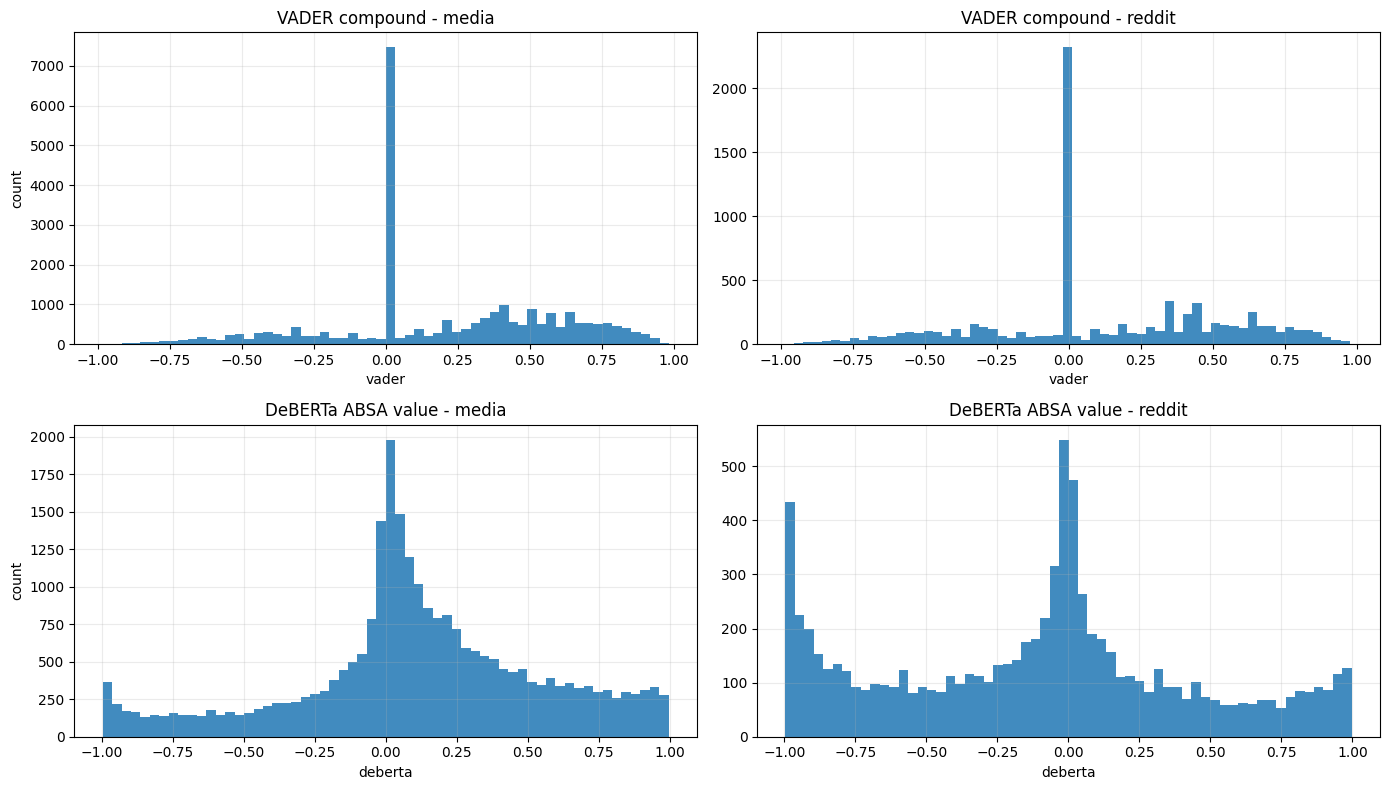

In [36]:
# Distributions of sentiment scores by source
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex="row")
for j, src in enumerate(["media", "reddit"]):
    d = sent_df[sent_df["source"] == src]
    axes[0, j].hist(d["vader"].dropna(), bins=60, alpha=0.85)
    axes[0, j].set_title(f"VADER compound - {src}")
    axes[0, j].set_xlabel("vader")

    axes[1, j].hist(d["deberta"].dropna(), bins=60, alpha=0.85)
    axes[1, j].set_title(f"DeBERTa ABSA value - {src}")
    axes[1, j].set_xlabel("deberta")

axes[0, 0].set_ylabel("count")
axes[1, 0].set_ylabel("count")
plt.tight_layout()


### Media-only: grades by tie_breaker

This directly answers: do pronoun-backfilled sentences look systematically different (more negative / more neutral / etc.) than explicitly matched sentences?

Snapshot (current run):
- `pronoun_backfill` is more neutral than explicit sentences (mean DeBERTa ~ **0.089** vs **0.149** for `single_player`; mean VADER ~ **0.178** vs **0.213**).

This motivates the later robustness check where we restrict media to `tie_breaker == single_player`.


In [37]:
media_tb_summary = (
    media_only.groupby("tie_breaker")
    .agg(
        n=("sentence", "size"),
        mean_vader=("vader", "mean"),
        mean_deberta=("deberta", "mean"),
        vader_pos_share=("vader_label", lambda s: float((s == "Positive").mean())),
        vader_neu_share=("vader_label", lambda s: float((s == "Neutral").mean())),
        vader_neg_share=("vader_label", lambda s: float((s == "Negative").mean())),
        deberta_pos_share=("deberta_label", lambda s: float((s == "Positive").mean())),
        deberta_neu_share=("deberta_label", lambda s: float((s == "Neutral").mean())),
        deberta_neg_share=("deberta_label", lambda s: float((s == "Negative").mean())),
    )
    .sort_values("n", ascending=False)
    .reset_index()
)
display(media_tb_summary)


,tie_breaker,n,mean_vader,mean_deberta,vader_pos_share,vader_neu_share,vader_neg_share,deberta_pos_share,deberta_neu_share,deberta_neg_share
0,pronoun_backfill,16789,0.178454,0.089288,0.510632,0.295789,0.193579,0.172792,0.717255,0.109953
1,single_player,7977,0.213475,0.148959,0.546571,0.293594,0.159835,0.307634,0.538924,0.153441
2,longest_alias_then_count_then_position,1245,0.241332,0.154179,0.572691,0.296386,0.130924,0.268273,0.603213,0.128514


## Model agreement (VADER vs DeBERTa)

We expect these models to disagree in many cases:
- VADER reacts strongly to certain lexicon cues, punctuation, and social-media style
- DeBERTa ABSA is target-aware but may behave differently when the sentence is factual or when the target is ambiguous

We look at:
- correlation of score values
- label confusion matrix
- examples of strong disagreements

Snapshot (current run): the score correlations are **modest** (Pearson r ~ **0.25** in media and ~ **0.32** in Reddit), and the label agreement rate is only about **0.40-0.42**.


,source,n,pearson_r,spearman_r
0,media,26011,0.254132,0.257024
1,reddit,8095,0.321517,0.318849


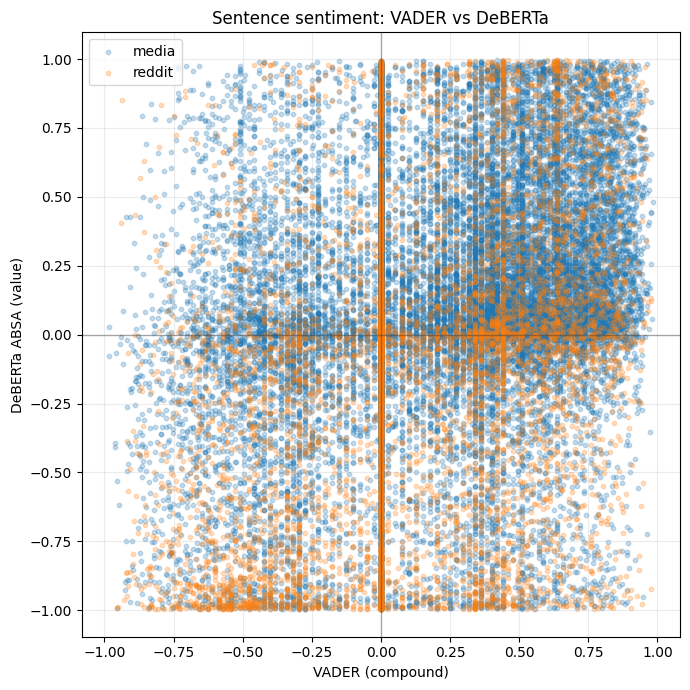

In [ ]:
def corr_table(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for src in ["media", "reddit"]:
        d = df[df["source"] == src].dropna(subset=["vader", "deberta"])
        if len(d) < 3:
            continue
        pearson_r = float(d[["vader", "deberta"]].corr(method="pearson").iloc[0, 1])
        spearman_r = float(d[["vader", "deberta"]].corr(method="spearman").iloc[0, 1])
        rows.append({"source": src, "n": len(d), "pearson_r": pearson_r, "spearman_r": spearman_r})
    return pd.DataFrame(rows)


display(corr_table(sent_df))

SAMPLE_N = 35_000
d0 = sent_df.dropna(subset=["vader", "deberta"]).copy()
sample = d0.sample(min(SAMPLE_N, len(d0)), random_state=42) if len(d0) else d0

fig, ax = plt.subplots(figsize=(7, 7))
colors = {"media": "tab:blue", "reddit": "tab:orange"}
for src, d in sample.groupby("source"):
    ax.scatter(d["vader"], d["deberta"], s=10, alpha=0.25, label=src, color=colors.get(src, None))

ax.axhline(0, color="k", linewidth=1, alpha=0.3)
ax.axvline(0, color="k", linewidth=1, alpha=0.3)
ax.set_xlabel("VADER (compound)")
ax.set_ylabel("DeBERTa ABSA (value)")
ax.set_title("Sentence sentiment: VADER vs DeBERTa")
ax.legend()
plt.tight_layout()


In [39]:
def confusion(df: pd.DataFrame, *, source: Optional[str] = None, normalize: str = "index") -> pd.DataFrame:
    d = df
    if source:
        d = d[d["source"] == source]
    return pd.crosstab(d["vader_label"], d["deberta_label"], normalize=normalize)


print("Confusion (normalize by VADER label):")
display(confusion(sent_df, normalize="index"))
print("Media-only:")
display(confusion(sent_df, source="media", normalize="index"))
print("Reddit-only:")
display(confusion(sent_df, source="reddit", normalize="index"))


Confusion (normalize by VADER label):


deberta_label,Negative,Neutral,Positive
vader_label,,,
Negative,0.331822,0.534300,0.133877
Neutral,0.135828,0.694189,0.169983
Positive,0.120952,0.618681,0.260367


Media-only:


deberta_label,Negative,Neutral,Positive
vader_label,,,
Negative,0.255333,0.593857,0.150811
Neutral,0.102253,0.719161,0.178585
Positive,0.091455,0.643925,0.264620


Reddit-only:


deberta_label,Negative,Neutral,Positive
vader_label,,,
Negative,0.517617,0.389637,0.092746
Neutral,0.242162,0.615099,0.142739
Positive,0.228549,0.526597,0.244854


In [40]:
# Strong disagreement examples (sanity check)
# Customize these thresholds if you want more/fewer examples.
VADER_POS = 0.5
VADER_NEG = -0.5
DEBERTA_POS = 0.5
DEBERTA_NEG = -0.5

cols = ["source", "player", "vader", "vader_label", "deberta", "deberta_label", "tie_breaker", "sentence"]

case_a = sent_df[(sent_df["vader"] >= VADER_POS) & (sent_df["deberta"] <= DEBERTA_NEG)].copy()
case_b = sent_df[(sent_df["vader"] <= VADER_NEG) & (sent_df["deberta"] >= DEBERTA_POS)].copy()

display(case_a.sort_values(["vader", "deberta"], ascending=[False, True])[cols].head(20))
display(case_b.sort_values(["vader", "deberta"], ascending=[True, False])[cols].head(20))


,source,player,vader,vader_label,deberta,deberta_label,tie_breaker,sentence
26997,reddit,Devin Booker,0.9749,Positive,-0.922190,Negative,(missing),I can’t tell the future but it’s pretty obviou...
25751,media,Aaron Holiday,0.9623,Positive,-0.721773,Negative,single_player,"Trading for Holiday will help, but surprisingl..."
27383,reddit,Jaxson Hayes,0.9485,Positive,-0.537501,Negative,(missing),he won 3 championships as a starter and litera...
6341,media,Ty Jerome,0.9467,Positive,-0.949989,Negative,single_player,With unrestricted free agent Ty Jerome perhaps...
33914,reddit,Ty Jerome,0.9448,Positive,-0.978015,Negative,(missing),Reaves is easily a much better play than Ty Je...
27030,reddit,Devin Booker,0.9398,Positive,-0.621289,Negative,(missing),"Yeah come on now folks, it's an overpay but it..."
26018,reddit,Brook Lopez,0.9349,Positive,-0.802147,Negative,(missing),"He's become extremely polarizing on our sub, h..."
31902,reddit,Jeff Green,0.9337,Positive,-0.853796,Negative,(missing),Houston got a top 10 scorer who’s still super ...
15956,media,Steven Adams,0.9294,Positive,-0.557069,Negative,pronoun_backfill,But this simple-minded Duterte fan appears con...
26523,reddit,Chris Paul,0.9253,Positive,-0.946513,Negative,(missing),The CP3 KD Booker Ayton Nets won a playoff se...


,source,player,vader,vader_label,deberta,deberta_label,tie_breaker,sentence
28211,reddit,Myles Turner,-0.9382,Negative,0.851283,Positive,(missing),"TJ McConnell and Myles Turner, who finished wi..."
32525,reddit,Myles Turner,-0.8702,Negative,0.570156,Positive,(missing),"Some numbers:\n\n- In the playoffs, in games w..."
56,media,Aaron Holiday,-0.8625,Negative,0.791736,Positive,pronoun_backfill,While his defense frustrates opponents endless...
26079,reddit,Brook Lopez,-0.8555,Negative,0.629302,Positive,(missing),If you ignore his 5 game season because of inj...
3705,media,Brook Lopez,-0.8481,Negative,0.691900,Positive,pronoun_backfill,“Art Detectives” (June 9 on Acorn TV): Stephen...
21256,media,Paolo Banchero,-0.8338,Negative,0.599175,Positive,pronoun_backfill,But Wagner proved them all wrong throughout hi...
7199,media,Shai Gilgeous-Alexander,-0.8316,Negative,0.835458,Positive,pronoun_backfill,He bounced back from a bad Game 1 to finish wi...
24669,media,Ty Jerome,-0.8160,Negative,0.781383,Positive,single_player,Cavs fans may be quick to condemn Jerome after...
21487,media,Paolo Banchero,-0.8047,Negative,0.660427,Positive,single_player,2024-25 was a season full of major injuries fo...
26113,reddit,Bruce Brown,-0.8020,Negative,0.679733,Positive,(missing),He’s top 10 offensive player no way he’s 3rd o...


## Sensitivity to other players noise

In the later overpay notebook, we often filter sentence records by `n_other_players` (how many *other tracked players* appear besides the target).

Here we explore what that filter does to:
- dataset size
- average sentiment
- model agreement

Snapshot (current run): restricting to `n_other_players <= 1` keeps almost all sentences (media **25,779/26,011 (~99.1%)**, Reddit **8,062/8,095 (~99.6%)**) and only slightly shifts mean sentiment. This suggests the filter mainly protects against rare multi-player ambiguity.


In [41]:
def summarize_with_threshold(df: pd.DataFrame, max_other_players: Optional[int]) -> pd.DataFrame:
    d = df
    if max_other_players is not None:
        d = d[d["n_other_players"] <= max_other_players]

    out = (
        d.groupby("source")
        .agg(
            n=("sentence", "size"),
            mean_vader=("vader", "mean"),
            mean_deberta=("deberta", "mean"),
            agreement=("label_agree", "mean"),
        )
        .reset_index()
    )
    out["max_other_players"] = "None" if max_other_players is None else int(max_other_players)
    return out


thresholds = [None, 0, 1, 2, 3]
thr_table = pd.concat([summarize_with_threshold(sent_df, t) for t in thresholds], ignore_index=True)
display(thr_table.sort_values(["source", "max_other_players"]))


,source,n,mean_vader,mean_deberta,agreement,max_other_players
2,media,24766,0.189734,0.108508,0.397077,0
4,media,25779,0.191383,0.109795,0.398037,1
6,media,25939,0.191919,0.110227,0.397355,2
8,media,25986,0.192140,0.110456,0.397214,3
0,media,26011,0.192204,0.110694,0.397101,None
3,reddit,7865,0.126495,-0.115713,0.420343,0
5,reddit,8062,0.128070,-0.111321,0.421111,1
7,reddit,8085,0.128473,-0.110490,0.421027,2
9,reddit,8091,0.128301,-0.110396,0.420962,3
1,reddit,8095,0.128374,-0.110121,0.420754,None


## Player-level aggregates (what we later model)

To move toward the overpay analysis, we need player-level features such as:
- number of sentences (coverage)
- average sentiment (per model)

Coverage is long-tailed even in this restricted free-agent cohort:
- Media: median **237** sentences/player (min 11, max 1,805)
- Reddit: median **66** sentences/player (min 1, max 787)

This motivates later robustness checks that focus on higher-volume players (top-N by sentiment volume).


In [42]:
# --- Build player-level aggregates (per source) ---

required = ["source", "player", "sentence", "vader", "deberta"]
missing = [c for c in required if c not in sent_df.columns]
if missing:
    raise ValueError(f"sent_df is missing required columns: {missing}")

player_src = (
    sent_df.groupby(["source", "player"], as_index=False)
    .agg(
        n_sentences=("sentence", "size"),
        mean_vader=("vader", "mean"),
        mean_deberta=("deberta", "mean"),
    )
)

player_src["log10_n"] = np.log10(player_src["n_sentences"].clip(lower=1))

display(player_src.sort_values(["source", "n_sentences"], ascending=[True, False]).head(10))


,source,player,n_sentences,mean_vader,mean_deberta,log10_n
9,media,Chris Paul,1805,0.220950,0.092896,3.256477
31,media,Jeff Green,1514,0.185181,0.057978,3.180126
57,media,Shai Gilgeous-Alexander,1495,0.191402,0.235503,3.174641
0,media,Aaron Holiday,1265,0.281427,0.096788,3.102091
5,media,Bruce Brown,1253,0.178862,0.126210,3.097951
16,media,Devin Booker,1225,0.180174,0.047817,3.088136
48,media,Myles Turner,1156,0.168446,0.131888,3.062958
12,media,Damian Lillard,886,0.159059,-0.048087,2.947434
50,media,Nigel Hayes-Davis,886,0.193646,0.098384,2.947434
25,media,Isaiah Jackson,801,0.136483,0.116993,2.903633


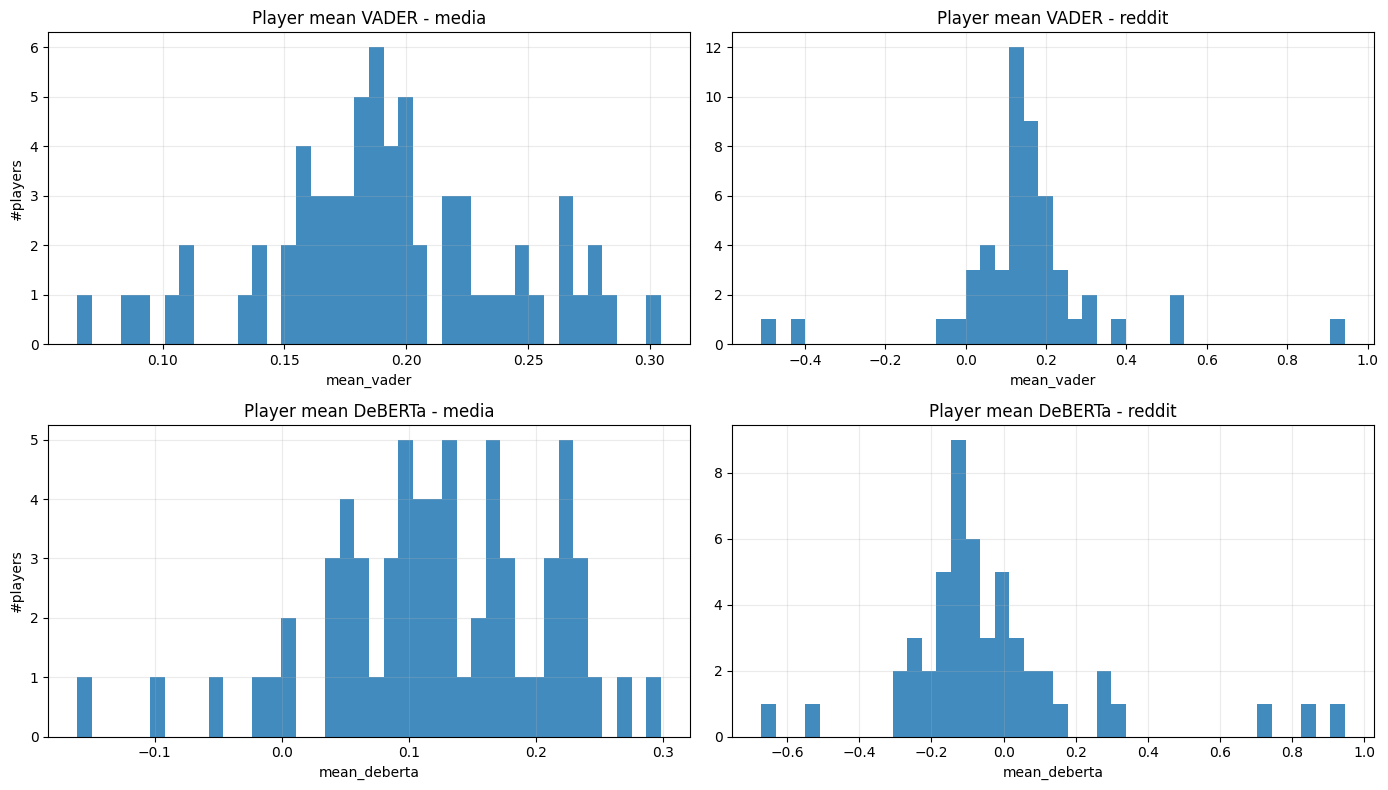

In [43]:
# Example: distribution of player-level mean sentiment (player-level averages)
#
# This is the *player-level* version of the earlier sentence-level histograms:
# each point/player is an average over that player's sentences, so the distribution
# is typically narrower (less extreme) than sentence-level sentiment.

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for j, src in enumerate(["media", "reddit"]):
    d = player_src[player_src["source"] == src]

    axes[0, j].hist(d["mean_vader"].dropna(), bins=40, alpha=0.85)
    axes[0, j].set_title(f"Player mean VADER - {src}")
    axes[0, j].set_xlabel("mean_vader")

    axes[1, j].hist(d["mean_deberta"].dropna(), bins=40, alpha=0.85)
    axes[1, j].set_title(f"Player mean DeBERTa - {src}")
    axes[1, j].set_xlabel("mean_deberta")

axes[0, 0].set_ylabel("#players")
axes[1, 0].set_ylabel("#players")
plt.tight_layout()


# Question: do more-talked-about players systematically look more positive/negative?

,source,metric,n_players,"spearman_r(n, metric)",spearman_p,"pearson_r(log10_n, metric)",pearson_p
0,media,mean_vader,66,-0.049767,0.691491,0.044123,0.725006
1,reddit,mean_vader,51,-0.126565,0.376151,-0.066541,0.642698
2,media,mean_deberta,66,-0.165334,0.184619,-0.000574,0.996348
3,reddit,mean_deberta,51,-0.225064,0.112314,-0.374056,0.006851


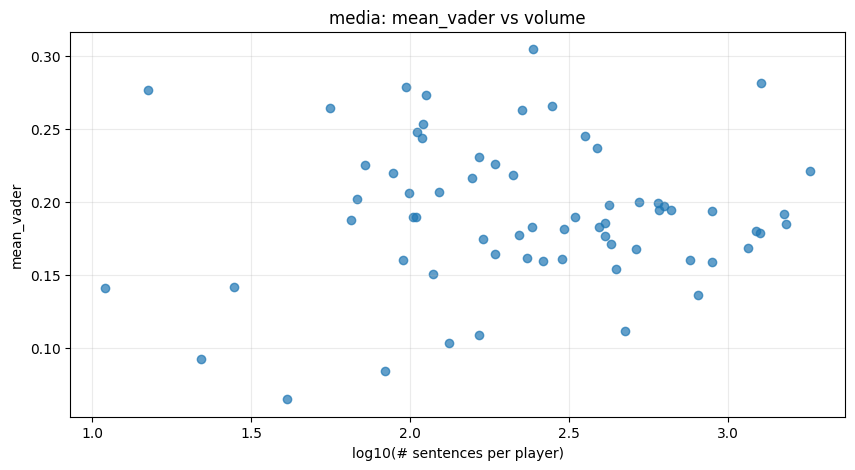

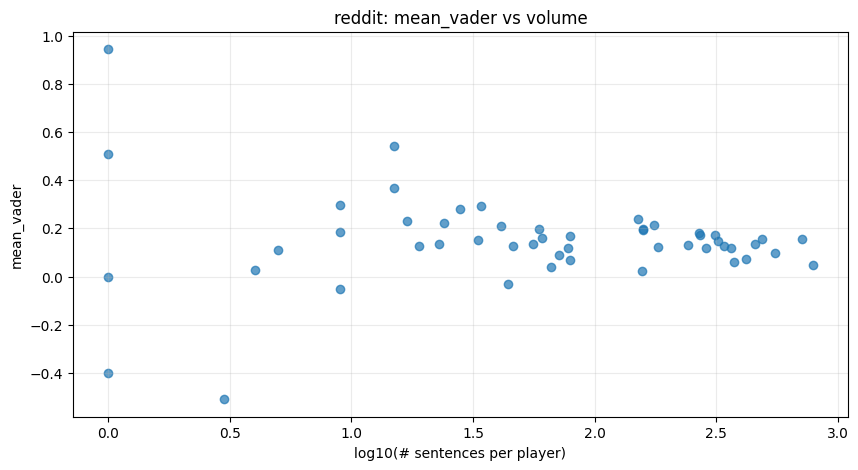

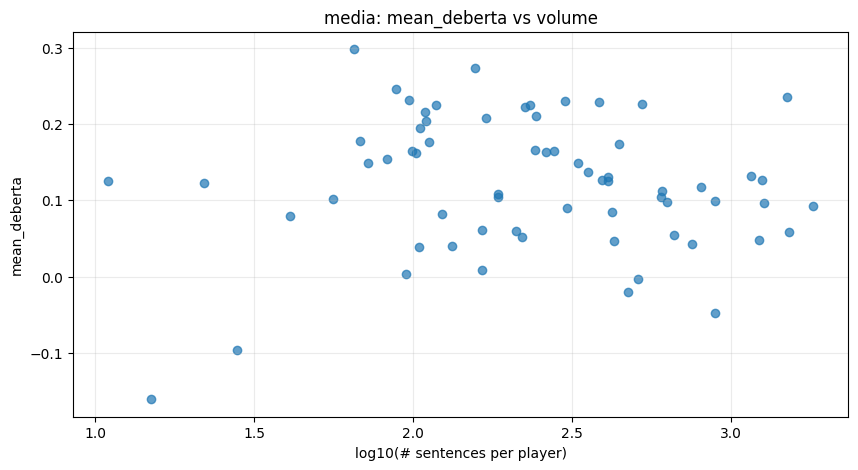

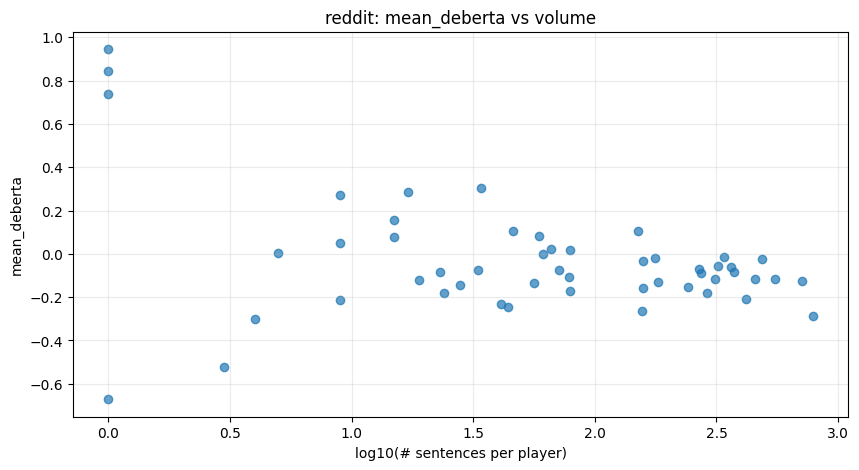

In [44]:

def vol_sent_stats(df, metric):
    rows = []
    for src in sorted(df["source"].unique()):
        d = df[df["source"] == src].dropna(subset=[metric, "n_sentences", "log10_n"]).copy()
        if len(d) < 3:
            continue

        # Spearman with raw n (rank-based, robust for long-tail)
        sp = stats.spearmanr(d["n_sentences"], d[metric], nan_policy="omit")
        # Pearson with log10(n) (more appropriate scale)
        pr = stats.pearsonr(d["log10_n"], d[metric])

        rows.append(
            {
                "source": src,
                "metric": metric,
                "n_players": len(d),
                "spearman_r(n, metric)": sp.statistic,
                "spearman_p": sp.pvalue,
                "pearson_r(log10_n, metric)": pr.statistic,
                "pearson_p": pr.pvalue,
            }
        )
    return pd.DataFrame(rows)

display(pd.concat([vol_sent_stats(player_src, "mean_vader"),
                   vol_sent_stats(player_src, "mean_deberta")], ignore_index=True))

# Plots (one per source x metric)
for metric in ["mean_vader", "mean_deberta"]:
    for src in sorted(player_src["source"].unique()):
        d = player_src[player_src["source"] == src].dropna(subset=[metric, "log10_n"])
        plt.figure()
        plt.scatter(d["log10_n"], d[metric], alpha=0.7)
        plt.xlabel("log10(# sentences per player)")
        plt.ylabel(metric)
        plt.title(f"{src}: {metric} vs volume")
        plt.show()


The aggregate sentiment looks mostly unrelated to the how many sentences for a player were gathered 

# Compare player-level means for players that appear in BOTH sources.

Players in both sources: 51


,metric,pearson_r,pearson_p,spearman_r,spearman_p
0,mean_vader,0.307663,0.028073,0.298371,0.033447
1,mean_deberta,0.232789,0.100196,0.416380,0.002372


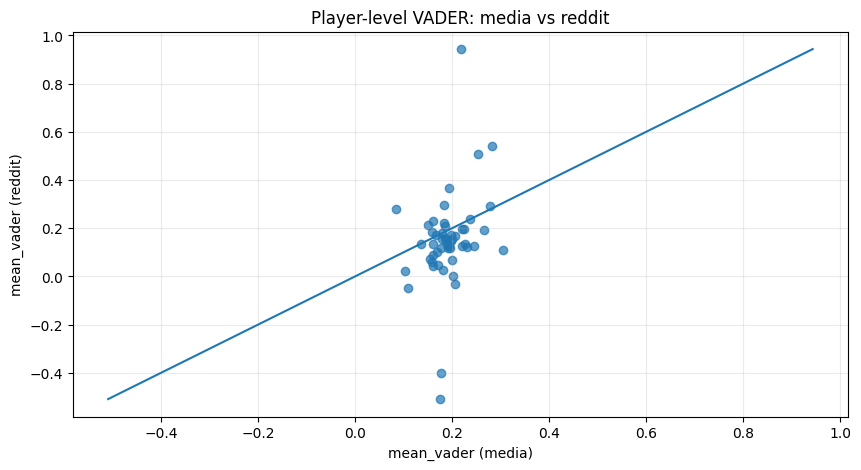

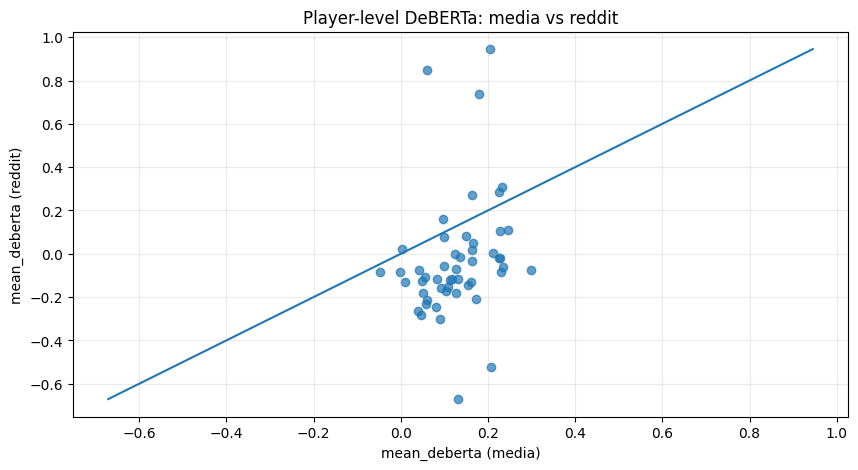

,player,n_sentences_media,n_sentences_reddit,mean_vader_media,mean_vader_reddit,abs_gap_vader
34,Jordan Clarkson,210.0,1.0,0.218730,0.943200,0.724470
6,Cam Spencer,169.0,3.0,0.174590,-0.508667,0.683257
22,Gary Harris,409.0,1.0,0.176416,-0.401900,0.578316
0,Aaron Holiday,1265.0,15.0,0.281427,0.542747,0.261319
47,Mason Plumlee,110.0,1.0,0.253069,0.509500,0.256431
2,Blake Wesley,123.0,44.0,0.206471,-0.032159,0.238630
32,Jericho Sims,68.0,1.0,0.202222,0.000000,0.202222
61,Tre Jones,83.0,28.0,0.084313,0.281675,0.197362
21,Fred VanVleet,243.0,5.0,0.304491,0.110400,0.194091
50,Nigel Hayes-Davis,886.0,15.0,0.193646,0.366733,0.173087


,player,n_sentences_media,n_sentences_reddit,mean_deberta_media,mean_deberta_reddit,abs_gap_deberta
22,Gary Harris,409.0,1.0,0.130039,-0.671237,0.801276
34,Jordan Clarkson,210.0,1.0,0.059713,0.846547,0.786834
47,Mason Plumlee,110.0,1.0,0.204057,0.945175,0.741119
6,Cam Spencer,169.0,3.0,0.207760,-0.520925,0.728684
32,Jericho Sims,68.0,1.0,0.178167,0.737353,0.559186
42,Lindy Waters III,304.0,4.0,0.089861,-0.300582,0.390443
8,Chet Holmgren,443.0,417.0,0.173081,-0.207400,0.380481
14,Dante Exum,65.0,33.0,0.297845,-0.076265,0.374110
30,Jaxson Hayes,428.0,787.0,0.046635,-0.284895,0.331530
2,Blake Wesley,123.0,44.0,0.081566,-0.245386,0.326952


In [45]:

# Pivot into wide format: mean_vader_media, mean_vader_reddit, etc.
wide = player_src.pivot_table(
    index="player",
    columns="source",
    values=["n_sentences", "mean_vader", "mean_deberta"],
    aggfunc="first",
)

# Flatten columns
wide.columns = [f"{a}_{b}".lower() for a, b in wide.columns]
wide = wide.reset_index()

# Try to infer expected source names (most likely "media" and "reddit")
cols = wide.columns.tolist()
need = ["mean_vader_media", "mean_vader_reddit", "mean_deberta_media", "mean_deberta_reddit"]
if not all(c in cols for c in need):
    print("Available wide columns:", cols)
    raise ValueError("Expected media/reddit columns not found. Check your source labels.")

both = wide.dropna(subset=["mean_vader_media", "mean_vader_reddit", "mean_deberta_media", "mean_deberta_reddit"]).copy()

print("Players in both sources:", len(both))

# Correlations
v_pr = stats.pearsonr(both["mean_vader_media"], both["mean_vader_reddit"])
v_sp = stats.spearmanr(both["mean_vader_media"], both["mean_vader_reddit"], nan_policy="omit")

d_pr = stats.pearsonr(both["mean_deberta_media"], both["mean_deberta_reddit"])
d_sp = stats.spearmanr(both["mean_deberta_media"], both["mean_deberta_reddit"], nan_policy="omit")

display(pd.DataFrame([
    {"metric": "mean_vader", "pearson_r": v_pr.statistic, "pearson_p": v_pr.pvalue, "spearman_r": v_sp.statistic, "spearman_p": v_sp.pvalue},
    {"metric": "mean_deberta", "pearson_r": d_pr.statistic, "pearson_p": d_pr.pvalue, "spearman_r": d_sp.statistic, "spearman_p": d_sp.pvalue},
]))

# Scatter plots with y=x reference line
def scatter_with_identity(x, y, xlabel, ylabel, title):
    plt.figure()
    plt.scatter(x, y, alpha=0.7)
    lo = float(np.nanmin([x.min(), y.min()]))
    hi = float(np.nanmax([x.max(), y.max()]))
    plt.plot([lo, hi], [lo, hi])  # identity line (default style/color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

scatter_with_identity(
    both["mean_vader_media"], both["mean_vader_reddit"],
    "mean_vader (media)", "mean_vader (reddit)",
    "Player-level VADER: media vs reddit"
)

scatter_with_identity(
    both["mean_deberta_media"], both["mean_deberta_reddit"],
    "mean_deberta (media)", "mean_deberta (reddit)",
    "Player-level DeBERTa: media vs reddit"
)

# Largest disagreements (useful for qualitative inspection)
both["abs_gap_vader"] = (both["mean_vader_media"] - both["mean_vader_reddit"]).abs()
both["abs_gap_deberta"] = (both["mean_deberta_media"] - both["mean_deberta_reddit"]).abs()

display(
    both.sort_values("abs_gap_vader", ascending=False)[
        ["player", "n_sentences_media", "n_sentences_reddit", "mean_vader_media", "mean_vader_reddit", "abs_gap_vader"]
    ].head(20)
)

display(
    both.sort_values("abs_gap_deberta", ascending=False)[
        ["player", "n_sentences_media", "n_sentences_reddit", "mean_deberta_media", "mean_deberta_reddit", "abs_gap_deberta"]
    ].head(20)
)


Fairly small correlation between how the deberta and vader compute the sentiment about given players. Not a positive finding for our study as it than looks that our sentiment estimators are on average really not alligned so if one has some predicting power the other likely wont allign and might predict the opposite

## Robustness: restrict MEDIA to higher-precision attribution (tie_breaker == single_player) this checks how much pronoun_backfill is influencing the aggregate.

,label,n_sentences,n_players,mean_vader,mean_deberta,label_agreement_rate,mean_n_other_players,share_no_other_players
0,media_all,26011,66,0.192204,0.110694,0.397101,0.061243,0.952136
1,media_single_player_only,7977,65,0.213475,0.148959,0.427730,0.000000,1.000000


Players meeting thresholds: 61


,metric,pearson_r(full vs single),pearson_p
0,mean_vader,0.651362,1.312423e-08
1,mean_deberta,0.856487,1.361760e-18


,player,n_full,n_single,mean_vader_full,mean_vader_single,delta_vader,abs_delta_vader
0,Aaron Holiday,1265,520,0.281427,0.449463,0.168036,0.168036
51,Paul Reed,185,40,0.226019,0.376425,0.150406,0.150406
12,Damian Lillard,886,194,0.159059,0.012419,-0.146640,0.146640
63,Ty Jerome,421,157,0.197917,0.317642,0.119725,0.119725
38,Kevon Looney,132,38,0.103520,0.218892,0.115372,0.115372
46,Mason Plumlee,110,14,0.253069,0.157879,-0.095191,0.095191
62,Trendon Watford,97,15,0.278630,0.373800,0.095170,0.095170
53,Ryan Rollins,225,68,0.262808,0.353069,0.090261,0.090261
10,Clint Capela,278,93,0.265590,0.180216,-0.085373,0.085373
45,Marvin Bagley III,95,20,0.160022,0.241435,0.081413,0.081413


,player,n_full,n_single,mean_deberta_full,mean_deberta_single,delta_deberta,abs_delta_deberta
12,Damian Lillard,886,194,-0.048087,-0.339465,-0.291377,0.291377
45,Marvin Bagley III,95,20,0.003747,0.206691,0.202944,0.202944
34,Jordan McLaughlin,104,26,0.039267,0.212738,0.173470,0.173470
50,Paolo Banchero,523,200,0.226458,0.396946,0.170488,0.170488
2,Blake Wesley,123,28,0.081566,-0.082309,-0.163875,0.163875
53,Ryan Rollins,225,68,0.222692,0.383717,0.161025,0.161025
22,Gary Trent Jr.,300,102,0.230016,0.389152,0.159135,0.159135
57,Steven Adams,393,111,0.127034,0.277218,0.150184,0.150184
29,Jaxson Hayes,428,115,0.046635,-0.093008,-0.139643,0.139643
62,Trendon Watford,97,15,0.231906,0.370037,0.138131,0.138131


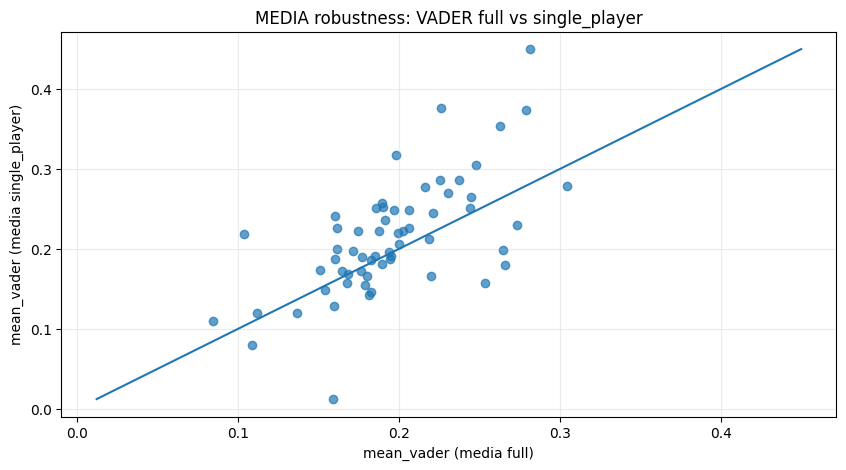

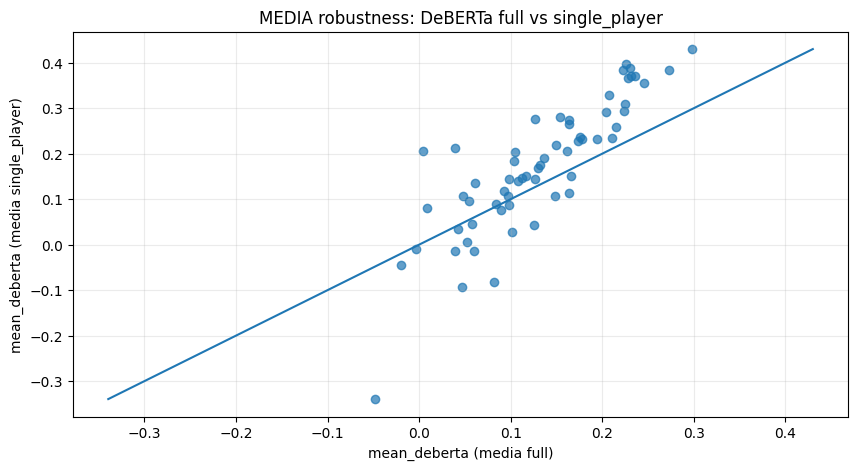

In [46]:


if "tie_breaker" not in sent_df.columns:
    raise ValueError("Column tie_breaker not found in sent_df. Can't run single_player robustness.")

media = sent_df[sent_df["source"] == "media"].copy()
media_single = media[media["tie_breaker"] == "single_player"].copy()

def corpus_summary(df, label=""):
    out = {
        "label": label,
        "n_sentences": len(df),
        "n_players": df["player"].nunique(),
        "mean_vader": df["vader"].mean(),
        "mean_deberta": df["deberta"].mean(),
    }
    if "label_agree" in df.columns:
        out["label_agreement_rate"] = df["label_agree"].mean()
    if "n_other_players" in df.columns:
        out["mean_n_other_players"] = df["n_other_players"].mean()
        out["share_no_other_players"] = (df["n_other_players"] == 0).mean()
    return out

display(pd.DataFrame([
    corpus_summary(media, "media_all"),
    corpus_summary(media_single, "media_single_player_only"),
]))

# Player-level comparison (full vs single_player) with optional min_n threshold
min_n_full = 30
min_n_single = 10

media_player_full = (
    media.groupby("player", as_index=False)
    .agg(n_full=("sentence", "size"), mean_vader_full=("vader", "mean"), mean_deberta_full=("deberta", "mean"))
)

media_player_single = (
    media_single.groupby("player", as_index=False)
    .agg(n_single=("sentence", "size"), mean_vader_single=("vader", "mean"), mean_deberta_single=("deberta", "mean"))
)

mcmp = media_player_full.merge(media_player_single, on="player", how="inner")

# Coverage thresholds (reduce noise)
mcmp_thr = mcmp[(mcmp["n_full"] >= min_n_full) & (mcmp["n_single"] >= min_n_single)].copy()
print("Players meeting thresholds:", len(mcmp_thr))

# Correlation of player-level means
v = stats.pearsonr(mcmp_thr["mean_vader_full"], mcmp_thr["mean_vader_single"])
d = stats.pearsonr(mcmp_thr["mean_deberta_full"], mcmp_thr["mean_deberta_single"])
display(pd.DataFrame([
    {"metric": "mean_vader", "pearson_r(full vs single)": v.statistic, "pearson_p": v.pvalue},
    {"metric": "mean_deberta", "pearson_r(full vs single)": d.statistic, "pearson_p": d.pvalue},
]))

# Biggest shifts (who changes most when restricting to single_player?)
mcmp_thr["delta_vader"] = mcmp_thr["mean_vader_single"] - mcmp_thr["mean_vader_full"]
mcmp_thr["delta_deberta"] = mcmp_thr["mean_deberta_single"] - mcmp_thr["mean_deberta_full"]
mcmp_thr["abs_delta_vader"] = mcmp_thr["delta_vader"].abs()
mcmp_thr["abs_delta_deberta"] = mcmp_thr["delta_deberta"].abs()

display(
    mcmp_thr.sort_values("abs_delta_vader", ascending=False)[
        ["player", "n_full", "n_single", "mean_vader_full", "mean_vader_single", "delta_vader", "abs_delta_vader"]
    ].head(20)
)

display(
    mcmp_thr.sort_values("abs_delta_deberta", ascending=False)[
        ["player", "n_full", "n_single", "mean_deberta_full", "mean_deberta_single", "delta_deberta", "abs_delta_deberta"]
    ].head(20)
)

# Scatter plots: full vs single_player (media)
scatter_with_identity(
    mcmp_thr["mean_vader_full"], mcmp_thr["mean_vader_single"],
    "mean_vader (media full)", "mean_vader (media single_player)",
    "MEDIA robustness: VADER full vs single_player"
)

scatter_with_identity(
    mcmp_thr["mean_deberta_full"], mcmp_thr["mean_deberta_single"],
    "mean_deberta (media full)", "mean_deberta (media single_player)",
    "MEDIA robustness: DeBERTa full vs single_player"
)
